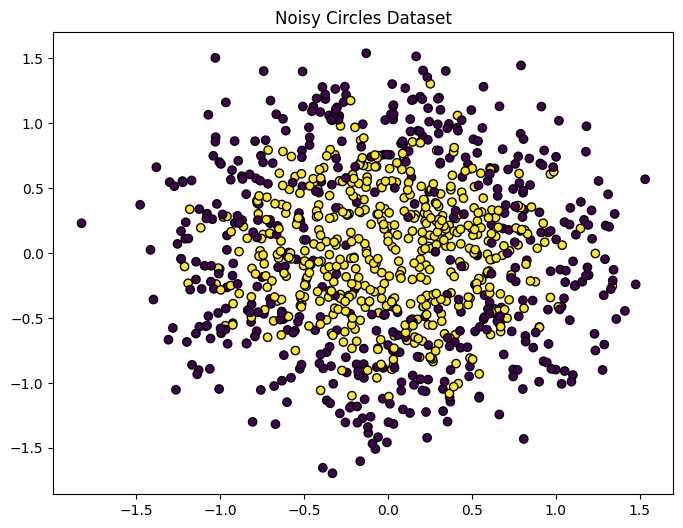

/Users/vpro/opt/anaconda3/envs/Torch_Info_theory/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training classical approach...
Epoch 0, Loss: 0.6920, Training Accuracy: 0.7300, Time: 0.0611s
Epoch 50, Loss: 0.4055, Training Accuracy: 0.8186, Time: 0.0029s
Epoch 100, Loss: 0.3947, Training Accuracy: 0.8286, Time: 0.0030s
Epoch 150, Loss: 0.3831, Training Accuracy: 0.8314, Time: 0.0029s
Epoch 200, Loss: 0.3704, Training Accuracy: 0.8386, Time: 0.0029s
Epoch 250, Loss: 0.3513, Training Accuracy: 0.8414, Time: 0.0029s
Epoch 300, Loss: 0.3409, Training Accuracy: 0.8414, Time: 0.0033s
Epoch 350, Loss: 0.3301, Training Accuracy: 0.8500, Time: 0.0031s
Epoch 400, Loss: 0.3208, Training Accuracy: 0.8443, Time: 0.0029s
Epoch 450, Loss: 0.3155, Training Accuracy: 0.8600, Time: 0.0035s
Classical Approach Test Accuracy: 0.6967
Classical Approach Total Time: 1.68s

Training progressive approach...
Progressive Approach Test Accuracy: 0.7133
Progressive Approach Total Time: 0.35s


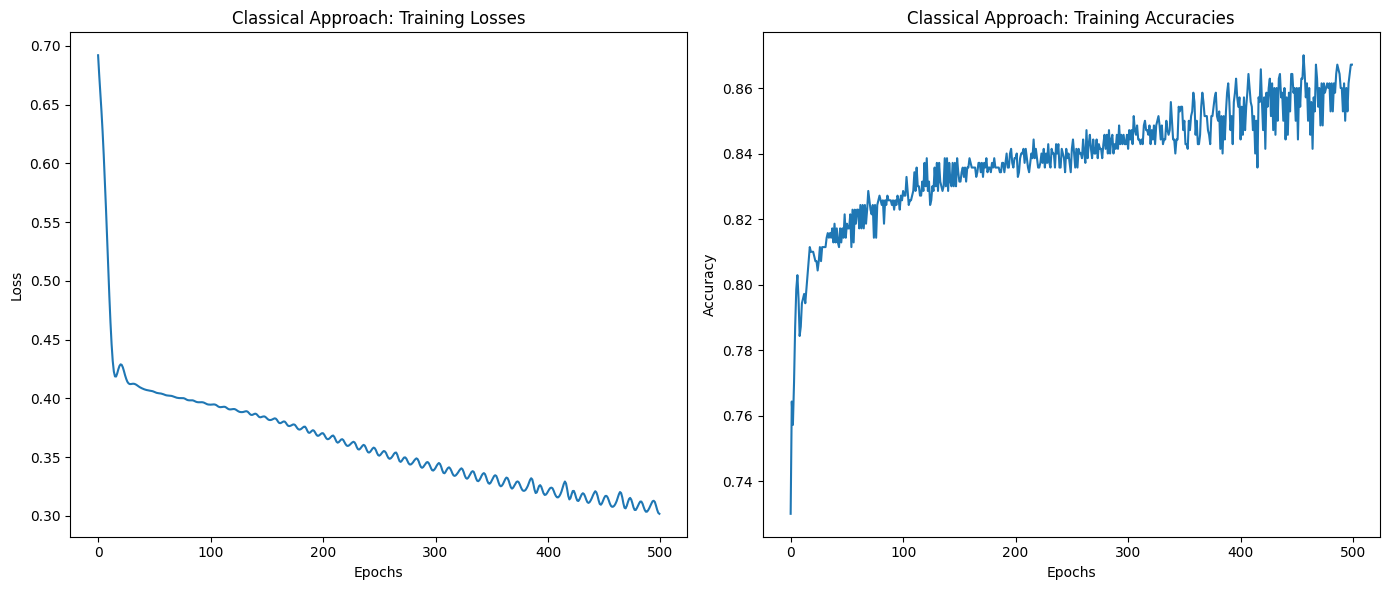

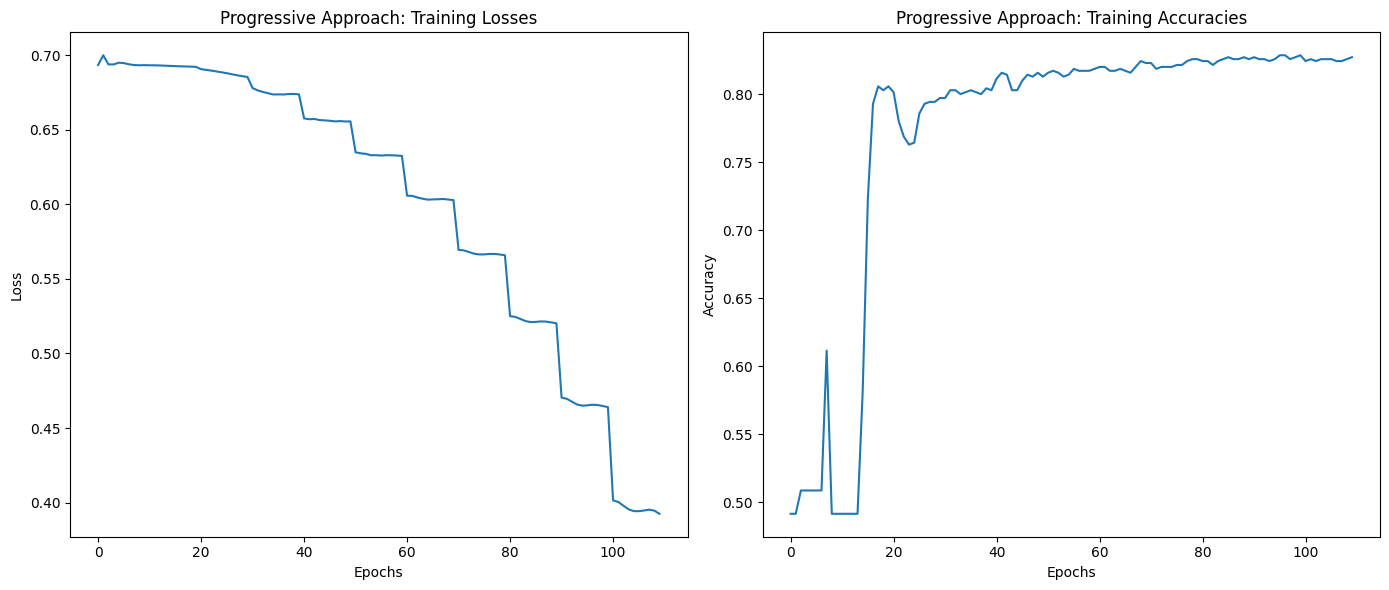

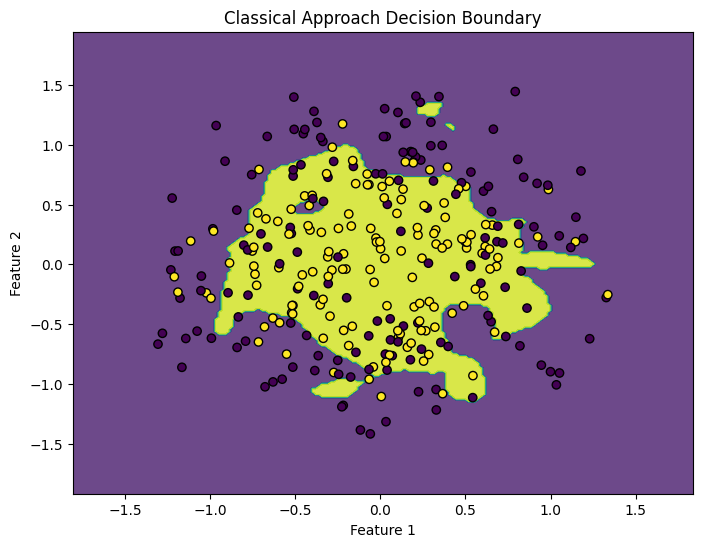

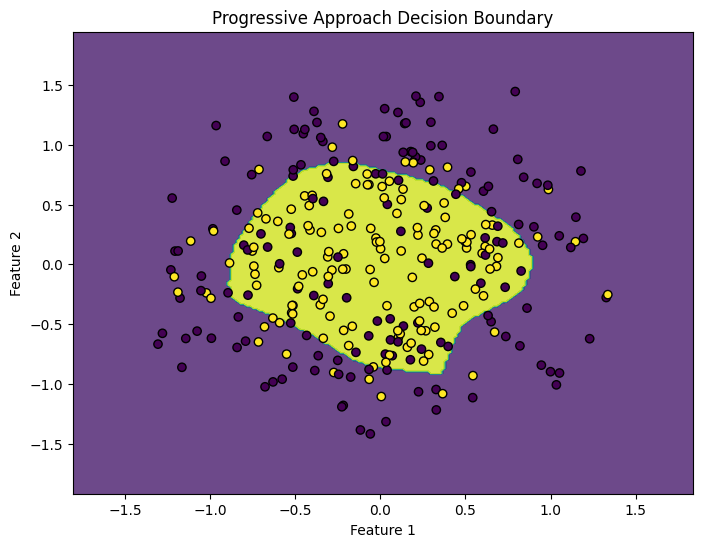

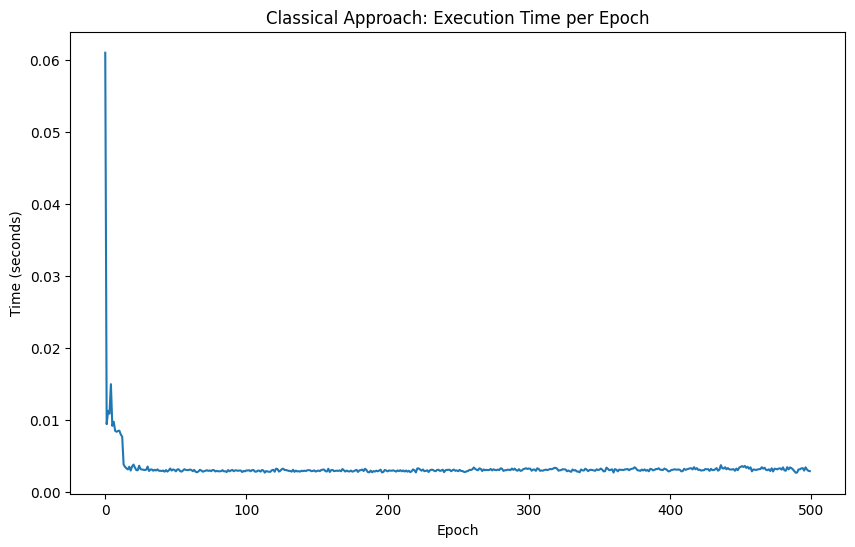

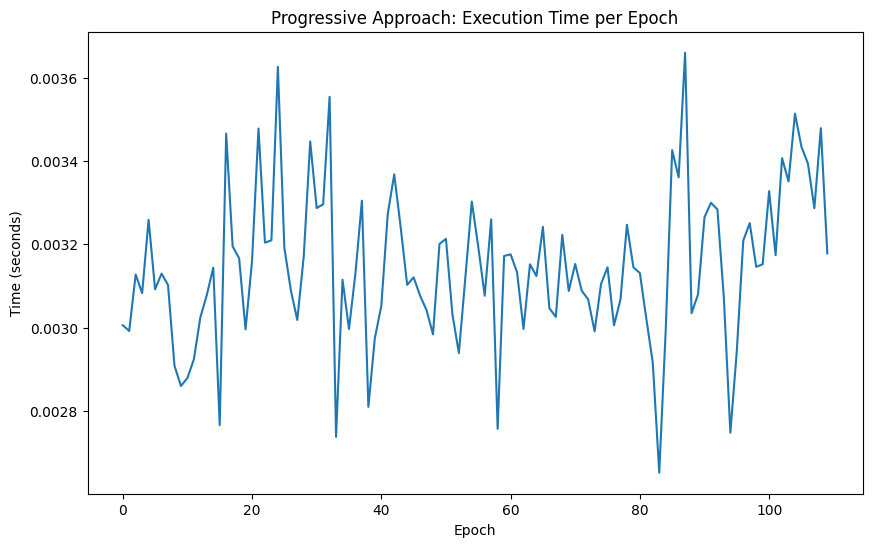


Total Execution Time:
Classical Approach: 1.68 seconds
Progressive Approach: 0.35 seconds


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import time

# Génération du jeu de données "Circles" avec du bruit
X, y = make_circles(n_samples=1000, noise=0.3, factor=0.5, random_state=42)

# Visualiser le jeu de données pour vérifier la complexité
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('Noisy Circles Dataset')
plt.show()

# Diviser en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Encodage One-Hot des étiquettes
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Conversion des données en tenseurs PyTorch
X_train = torch.FloatTensor(X_train)
y_train_onehot = torch.FloatTensor(y_train_onehot)
X_test = torch.FloatTensor(X_test)
y_test_onehot = torch.FloatTensor(y_test_onehot)

# Définition du modèle complexe pour favoriser l'overfitting
class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Fonction d'entraînement pour l'approche classique
def train_classical(model, X_train, y_train_onehot, epochs=500):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    epoch_times = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train_onehot)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_accuracies.append(evaluate(model, X_train, y_train_onehot))
        
        epoch_end = time.time()
        epoch_times.append(epoch_end - epoch_start)
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Training Accuracy: {train_accuracies[-1]:.4f}, Time: {epoch_times[-1]:.4f}s')
    
    total_time = time.time() - start_time
    return train_losses, train_accuracies, epoch_times, total_time

# Fonction d'entraînement pour l'approche progressive
def train_progressive(model, X_train, y_train_onehot, epsilon=1e-2, epochs_per_increment=10, increment_step=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    targets = torch.zeros_like(y_train_onehot) + 1/2
    train_losses = []
    train_accuracies = []
    epoch_times = []
    start_time = time.time()
    
    for t in np.arange(0, 1.0 + increment_step, increment_step):
        targets = t * y_train_onehot + (1 - t) * (1/2)
        for epoch in range(epochs_per_increment):
            epoch_start = time.time()
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(evaluate(model, X_train, y_train_onehot))
            
            epoch_end = time.time()
            epoch_times.append(epoch_end - epoch_start)
            
            if loss.item() < epsilon:
                break
    
    total_time = time.time() - start_time
    return train_losses, train_accuracies, epoch_times, total_time

# Fonction d'évaluation
def evaluate(model, X, y_onehot):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        _, actual = torch.max(y_onehot, 1)
        accuracy = (predicted == actual).sum().item() / actual.size(0)
    return accuracy

# Entraînement et évaluation de l'approche classique
model_classic = ComplexNN()
print("Training classical approach...")
classic_losses, classic_accuracies, classic_epoch_times, classic_total_time = train_classical(model_classic, X_train, y_train_onehot, epochs=500)
accuracy_classic = evaluate(model_classic, X_test, y_test_onehot)
print(f'Classical Approach Test Accuracy: {accuracy_classic:.4f}')
print(f'Classical Approach Total Time: {classic_total_time:.2f}s')

# Entraînement et évaluation de l'approche progressive
model_progressive = ComplexNN()
print("\nTraining progressive approach...")
progressive_losses, progressive_accuracies, progressive_epoch_times, progressive_total_time = train_progressive(model_progressive, X_train, y_train_onehot)
accuracy_progressive = evaluate(model_progressive, X_test, y_test_onehot)
print(f'Progressive Approach Test Accuracy: {accuracy_progressive:.4f}')
print(f'Progressive Approach Total Time: {progressive_total_time:.2f}s')

# Fonction pour tracer les courbes de perte et de précision pour chaque approche
def plot_losses_and_accuracies(losses, accuracies, method):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title(f'{method} Approach: Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title(f'{method} Approach: Training Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

# Tracer les courbes de perte et de précision pour l'approche classique
plot_losses_and_accuracies(classic_losses, classic_accuracies, 'Classical')

# Tracer les courbes de perte et de précision pour l'approche progressive
plot_losses_and_accuracies(progressive_losses, progressive_accuracies, 'Progressive')

# Fonction pour tracer les frontières de décision
def plot_decision_boundary(model, X, y, title):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = torch.argmax(Z, dim=1).reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# Tracer les frontières de décision pour l'approche classique
plot_decision_boundary(model_classic, X_test.numpy(), y_test, 'Classical Approach Decision Boundary')

# Tracer les frontières de décision pour l'approche progressive
plot_decision_boundary(model_progressive, X_test.numpy(), y_test, 'Progressive Approach Decision Boundary')

# Fonction pour tracer les temps d'exécution par époque
def plot_epoch_times(epoch_times, method):
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_times)
    plt.title(f'{method} Approach: Execution Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.show()

# Tracer les temps d'exécution par époque pour l'approche classique
plot_epoch_times(classic_epoch_times, 'Classical')

# Tracer les temps d'exécution par époque pour l'approche progressive
plot_epoch_times(progressive_epoch_times, 'Progressive')

# Afficher le temps total d'exécution pour chaque approche
print(f"\nTotal Execution Time:")
print(f"Classical Approach: {classic_total_time:.2f} seconds")
print(f"Progressive Approach: {progressive_total_time:.2f} seconds")
